# Simplification d'ensembles de stratégies

In [1]:
%run ../src/game.py
%run ../src/ipd.py
%run ../src/strategies.py
%run ../src/tools.py
g.prettyPrint()   # prisoner's dilemma

        C       D
C  [3, 3]  [0, 5]
D  [5, 0]  [1, 1]


Deux stratégies au dilemme itéré du prisonnier sont équivalentes si quelque soit l'adversaire et quelle que soit la durée de la partie, elles jouent les mêmes coups exactement. Les ensembles de stratégies que nous traitons sont donc parfois redondants : il contiennent les mêmes stratégies écrites de différentes manières. Il semble donc interessant de pouvoir simplifier des ensembles de stratégies en suprimant les doublons qu'ils peuvent contenir. 
Malheureusement, chacun le sait depuis Turing, l'équivalence de deux programmes est indécidable. Il n'y a donc pas de test parfait. Il est néanmoins possible de fournir des outils permettant d'avancer dans ce problème de simplification.


## Tests approximatifs d'équivalences de stratégies

Pour savoir si deux stratégies sont différentes, il suffit de les faire jouer contre une stratégie de référence et s'assurer qu'elles jouent différemment face à cet adversaire. Evidemment selon la complexité de cette stratégie de référence, le test est plus ou moins efficace. Si les stratégies jouent la même chose, cela ne fournit néanmoins pas une preuve de leur équivalence. L'équivalence est semi-décidable : si les stratégies jouent différemment il est sûr qu'elles sont différentes, mais si elles jouent de manière identique, c'est peut-etre que la stratégie de référence n'a pas sû révéler leur différence de comportement.
La fonction `testEquivUnit` réalise ce test. On lui passe un couple de stratégies à tester et une stratégie de référence `opponent`, et elle compare ces deux stratégies durant `length` tours d'un meeting. Elle renvoie un booléen : équivalent (avec doute) ou pas.

In [ ]:
def testEquivUnit(strategies, opponent, length):
    sA,sB = strategies
    rounds1 = []
    rounds2  = []
    m1 = Meeting(g, sA, opponent, length)
    m1.run()
    m2 = Meeting(g, sB, opponent, length)
    m2.run()
    if m1.s1_score == m2.s1_score :
        if m1.s1_rounds == m2.s1_rounds :
            return True
    return False


# example of use
print(testEquivUnit((Tft(), Spiteful())  , Periodic("CCDCD"), 100))     # False
print(testEquivUnit((Tft(), Mem(0,1,"cCD")),  Periodic("CCDCD"), 100))  # true

Le choix de la stratégie de référence est capital. Si elle est trop "faible", elle ne permet pas aux deux stratégies comparées de se "révéler" et indique alors qu'elles sont équivalentes alors qu'elles ne le sont pas, comme ci-dessous : `Tft` et `Spiteful` sont clairement différentes, et pourtant, face  `All_C` elles ont le même comportement.


In [ ]:
testEquivUnit((Tft(), Spiteful()), Periodic('C'), 100)   
# says True, but it's False

Un test plus robuste pourrait consister à faire jouer ces deux stratégies contre `Periodic('CCD')`. Cette dernière permet à `Tft` et `Spiteful` de révéler leur véritable comportement. On a cette fois ci la preuve que ces deux stratégies ne sont pas équivalentes.

In [ ]:
testEquivUnit((Tft(), Spiteful()), Periodic('CD'), 100)

### Exercice 1

Deux stratégies peuvent bien évidemment obtenir le même score face à un adversaire commun, tout en ayant joué des coups différents. Pouvez vous identifier un tel cas ? On pourra utiliser le package `itertools` et sa méthode `permutations` qui permet facilement de prendre 3 stratégies parmi `n`

In [ ]:
def test2(strategies, opponent, length):
    sA,sB = strategies
    rounds1 = []
    rounds2  = []
    m1 = Meeting(g, sA, opponent, length)
    m1.run()
    m2 = Meeting(g, sB, opponent, length)
    m2.run()
    if m1.s1_score == m2.s1_score :
        if m1.s1_rounds != m2.s1_rounds :  # THE TEST HAS CHANGED COMPARED TO testEquivUnit
            return True
    return False


# example of use
bag = getMem(1,0)
bags = itertools.permutations(bag, 3)
for b in bags : 
    if test2((b[0], b[1]), b[2], 10):
        print(b[0].name + " and "+b[1].name+" produce the same score but don't play the same rounds against : "+b[2].name)            
        break

        
        
#sA = Mem(1,1,"CCCCC")
#sB = Mem(1,1,"CCDDC")
#opponent = Mem(1,1,"DCDCC")
#m = Meeting(g,sA,opponent,10)
#m.run()
#print(m.s1.name + "\t" + ' '.join(map(str, m.s1_rounds)) + " " + str(m.s1_score))
#print(m.s2.name + "\t" + ' '.join(map(str, m.s2_rounds)) + " " + str(m.s2_score))
#print()
#m = Meeting(g,sB,opponent,10)
#m.run()
#print(m.s1.name + "\t" + ' '.join(map(str, m.s1_rounds)) + " " + str(m.s1_score))
#print(m.s2.name + "\t" + ' '.join(map(str, m.s2_rounds)) + " " + str(m.s2_score))

Afin d'améliorer cette comparaison de deux stratégies, il est préférable de les comparer non pas à une seule stratégie de référence, mais à un ensemble de stratégies de référence. On compare nos deux stratégies contre chaque élément de cet ensemble, ce qui constitue un test surement plus robuste. Bien évidemment dès que l'une de celles-ci indique une différence entre deux 2 stratégies, le test peut s'arrêter.
La fonction `testEquivMultiple` fonctionne comme précédemment, mais cette fois en cherchant à trouver une différence de comportement grâce à une liste d'opposants. Comme précédemment elle renvoie un booléen : équivalent (avec doute) ou pas.

In [ ]:
def testEquivMultiple(strategies, opponents, length):
    for opponent in opponents : 
        equiv = testEquivUnit(strategies, opponent, length)
        if equiv == False :
            return False
    return True

# example of use
# Same test than previously, but this time, it says False
testEquivMultiple((Tft(), Spiteful()),[Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)

Pour simplifier un ensemble de stratégies, il suffit maintenant d'effectuer le test précédent sur tous les couples possibles. Les stratégies identifiées comme potentiellement équivalentes sont alors regroupées.
la fonction `classesEquiv(l, opponents, length)` effectue ce test sur l'ensemble `l`. Elle renvoie dans un dictionnaire les classes d'équivalence identifiées.
Par exemple si on a strat1 équivalente à strat2 ainsi que strat3 qui elle n'a pas d'équivalente, la fonction va renvoyer un dictionnaire : `{strat1 : [strat2] , strat3 : []}`

L'ensemble des clés de ce dictionnaire constitue l'ensemble de stratégies simplifié, et chaque entrée du dictionnaire correspond à un ensemble de stratégies équivalentes. Pour des ensembles complets de stratégies `Mem(X,Y)`, pour des raisons de symétrie, le nombre de stratégies équivalentes à une stratégie fixée est toujours une puissance de 2 (0, 2, 4, 8, 16 ...)

In [ ]:
def classesEquiv(l, opponents, length):
    m = dict()
    while len(l) > 0 :
        m[l[0]] = []
        ind = [0]
        for j in range(len(l[1:])):
            if testEquivMultiple([l[0], l[j + 1]], opponents, length):
                m[l[0]] += [l[j + 1]]
                ind += [j + 1]
        ltmp = []
        for i in range(len(l)):
            if i not in ind :
                ltmp += [l[i]]
        l = ltmp
    return m


# This function allows you to display the names of the strategies instead of the instance number.
def printDict(ce):
    for key in ce.keys() :
        if len(ce[key]) > 0:
            print("\n" + key.name + " : " , end =" " )
        else :
            print("\n"+ key.name + ": []"  , end =" ")
        for value in ce[key]:
            print(value.name , end =" ")
    print(" ")
    

# example of use
# There is one Mem equivalent to Tft and one Mem equivalent to Spiteful. This lead 3 classes
L = [Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC") ]
ce = classesEquiv(L, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
printDict(ce)
print("Simplified set size : " + str(len(ce.keys())))

On rappelle que la qualité de cette simplification dépend très fortement de la qualité de la liste de référence. On le constate aisément en tentant de simplifier `mem(1,2)` face à une liste de plus en plus grande de stratégies de référence.


In [ ]:
# Mem(1,2) contains 1024 strategies

# Without any opponent, they are all considered equivalent.
ce = classesEquiv(getMem(1,2), [], 10)
print(len(ce.keys()))

# Comparing with simply ALL_C , only 9 different strategies are available
ce = classesEquiv(getMem(1,2), [Periodic('C')], 10)
print(len(ce.keys()))

# We're gradually strengthening the test
ce = classesEquiv(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
print(len(ce.keys()))

ce = classesEquiv(getMem(1,2), [Periodic('C'), Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()], 10)
print(len(ce.keys()))

# So? How large is this simplified set really?


On peut encore renforcer le test en commençant par faire jouer toutes les stratégies de l'ensemble à tester entre elles. Bien évidemment si des stratégies sont identiques, elles doivent avoir le même score dans ce tournoi. On peut donc se contenter de tester les équivalences sur les ensembles de stratégies qui obtiennent en tournoi un score identique. Rajouter cette équivalence des scores renforce encore un peu plus notre test.
Bien évidemment ceci se fait au détriment du temps de calcul.
La fonction `simplifyWithTournament` effectue ce travail. Elle fonctionne comme précédemment mais démarre par un tournoi afin d'identifier les paquets de stratégies ayant le même score. On concatène ensuite chacun des dictionnaires

In [ ]:
def simplifyWithTournament(l, opponents, length):
    scores = dict()
    t = Tournament(g, opponents + l, length)
    t.run()
    res = t.matrix['Total']
    for strat in l : 
        score = res[strat.name]
        if score not in scores :
            scores[score] = [strat]
        else : 
            scores[score] += [strat]
    
    d = dict()
    for item in scores.values():
        # if more than one strategy have the same score, test classesEquiv
        if len(item) > 1 :
            res = classesEquiv(item, opponents, length)
            for it in res.keys():
                d[it] = res[it]
        else : 
            d[item[0]] = []
    return d

        
    
# example of use        
#strats = simplifyWithTournament(getMem(1,2) , [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
#print("Simplified set size : " + str(len(strats)))

# RECORD BROKEN! 820... but this test remains undecidable, it is nevertheless subject to a doubt...       
# printDict(strats)  

### Tableau de synthèse

Etant donnée une base de comparaison, il est facile d'afficher un tableau contenant pour chacune des classes de Memory classiques, la synthèse des tailles obtenues après simplication via `ClassesEquiv` et via `SimplifyWithTournament` afin de voir la différence.

In [ ]:
base  = [Periodic('CDCCDDC'), Periodic('DDCDCDD'),Gradual()]

Mem01 = getMem(0,1)
Mem10 = getMem(1,0)
Mem11 = getMem(1,1)
Mem12 = getMem(1,2)
Mem21 = getMem(2,1)

ce01 = classesEquiv(Mem01, base, 10)
ce10 = classesEquiv(Mem10, base, 10)
ce11 = classesEquiv(Mem11, base, 10)
ce12 = classesEquiv(Mem12, base, 10)
ce21 = classesEquiv(Mem21, base, 10)

simp01 = simplifyWithTournament(Mem01, base, 10)
simp10 = simplifyWithTournament(Mem10, base, 10)
simp11 = simplifyWithTournament(Mem11, base, 10)
simp12 = simplifyWithTournament(Mem12, base, 10)
simp21 = simplifyWithTournament(Mem21, base, 10)

# idem avec simplify

tab = pd.DataFrame(
        np.nan, ["Mem 0 1","Mem 1 0","Mem 1 1", "Mem 1 2", "Mem 2 1"], ["All strategies", "After classesEquiv","After simplifyWithTournament"]
    )
tab.at["Mem 0 1", "All strategies" ] = len(Mem01)
tab.at["Mem 1 0", "All strategies" ] = len(Mem10)
tab.at["Mem 1 1", "All strategies" ] = len(Mem11)
tab.at["Mem 1 2", "All strategies" ] = len(Mem12)
tab.at["Mem 2 1", "All strategies" ] = len(Mem21)
tab.at["Mem 0 1", "After classesEquiv" ] = len(ce01.keys())
tab.at["Mem 1 0", "After classesEquiv" ] = len(ce10.keys())
tab.at["Mem 1 1", "After classesEquiv" ] = len(ce11.keys())
tab.at["Mem 1 2", "After classesEquiv" ] = len(ce12.keys())
tab.at["Mem 2 1", "After classesEquiv" ] = len(ce21.keys())
tab.at["Mem 0 1", "After simplifyWithTournament" ] = len(simp01.keys())
tab.at["Mem 1 0", "After simplifyWithTournament" ] = len(simp10.keys())
tab.at["Mem 1 1", "After simplifyWithTournament" ] = len(simp11.keys())
tab.at["Mem 1 2", "After simplifyWithTournament" ] = len(simp12.keys())
tab.at["Mem 2 1", "After simplifyWithTournament" ] = len(simp21.keys())
tab

### Améliorer l'affichage des stratégies

Les classes d'équivalence permettent de mettre en évidence des ensembles de stratégies qui jouent de manière identique. Dans le cas des `Mem(X,Y)`, par construction, ces stratégies identiques ont une partie de leur génotype en commun.
Il est alors interessant d'afficher les ensembles de stratégies équivalentes par une seule et même représentation en remplaçant les coups qui ne sont pas impactant par des * . On passe à cette méthode un ensemble de stratégies identifiées comme équivalentes, la méthode fusionne ces noms pour fournir une notation avec * . Attention : cette méthode ne fonctionne que pour des `Mem(X,Y)`, ne calcule pas et ne vérifie pas l'équivalence, elle suppose que les stratégies fournies sont équivalentes.

In [ ]:
def computeStar(strategies):
    l = math.log2(len(strategies))
    assert l == int(l)
    ind_stars = []
    len_genome = len(strategies[0].genome)
    amorce = max(strategies[0].x, strategies[0].y)
    for i in range(amorce, len_genome):
        letter = strategies[0].genome[i]
        for j in range(1, len(strategies)):
            if letter != strategies[j].genome[i]:
                ind_stars += [i]
                break
    #assert len(ind_stars) == l
    new_genome = strategies[0].genome[0 : amorce ]
    for i in range(amorce, len_genome):
        if i not in ind_stars:
            new_genome += strategies[0].genome[i]
        else :
            new_genome += "*"
    #print(new_genome)
    return new_genome


# example of use
print(computeStar([Mem(1,1,"cCDCD"),Mem(1,1,"cCDCC")]))
print(computeStar([Mem(1,2,"CDCCDDDCDC"),Mem(1,2,"CDCDDDDCDC"),Mem(1,2,"CDDCDDDCDC"),Mem(1,2,"CDDDDDDCDC")]))
print(computeStar([Mem(1,2,"DDDDCCCDCD"),Mem(1,2,"DDDDCDCDCD"),Mem(1,2,"DDDDDCCDCD"),Mem(1,2,"DDDDDDCDCD")]))

print(computeStar([Mem(1,2,"ccCDCDCCDD"),Mem(1,2,"ccDDDDCDDC")])) 

## Comparer une classe complète et sa classe simplifiée

Nous avons maintenant tous les outils permettant, non seulement de simplifier une classe, de rejouer cette classe simplifiée, et de comparer les résultats.
Prenons l'exemple des `Mem(1,1)`. Cette classe contient 32 stratégies. Une fois simplifiée il en reste 26. Grâce à `computeStar`on peut maintenant mettre le nom générique dans la légende. On constate que les deux compétitions écologiques donnent les mêmes 4 premiers. On note que dans la classe simplifiée les All_C survivent, alors qu'elles disparaissent dans la classe complète.

In [ ]:
# Calcul de la classe simplifiée
mem11 = getMem(1,1)
simpl = simplifyWithTournament(mem11, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
print(len(simpl))

# Remplacement des noms par des noms génériques
bag = []
for key in simpl.keys():
    if len(simpl[key]) > 0:
        name = computeStar([key]+simpl[key])
        bag += [key.clone(name)]
    else :
        bag += [key]

# Evolution de la classe initiale
e1 = Ecological(g, mem11)
e1.run()

evol=e1.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e1.drawPlot(None,nbSurvivors)

# Evolution de la classe simplifiée avec ses noms génériques
e2 = Ecological(g, bag)
e2.run()

evol=e2.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e2.drawPlot(None,10)


## Une simplification progressive

Dans le cas des grandes classes il est impossible de faire fonctionner le tournoi et donc la méthode de simplification par le tournoi ne peut pas fonctionner. Néanmoins, on peut ne prendre qu'une partie raisonnable de la classe à laquelle on s'interesse, la simplifier par le tournoi. On ajoute un certain nombre de stratégies à cet ensemble simplifié sans dépasser la taille maximum raisonnable que l'on s'est fixé, et on recommence. Si à un moment donné aucune simplification n'est possible, cette méthode échoue dans la simplification. Il faut éventuellement changer l'ordre dans lequel on prend les stratégies (en espérant que cet ordre favorisera les simplifications), ou alors si c'est possible, augmenter la taille maximale que l'on s'est fixé. Il est évident que cette méthode ne fonctionne que si la taille que l'on s'est fixé dépasse la taille de l'ensemble simplifié à obtenir (820 minimum pour `Mem(1,2)` par exemple).

In [ ]:
def sort1_Mem(strategies):
    strategies.sort(key=lambda x: x.genome)
    return strategies

def sort2_Mem(strategies):
    strategies.sort(key=lambda x: x.genome, reverse=True)
    return strategies

def sort3_Mem(strategies):
    strategies.sort(key=lambda x: ''.join(reversed(x.genome)))
    return strategies

def sort4_Mem(strategies):
    strategies.sort(key=lambda x: ''.join(reversed(x.genome)), reverse=True)
    return strategies


sortMem11 = sort4_Mem(getMem(1,1))


In [ ]:
def simplifyStepByStep(l, opponents, length, batchSize):
    size = len(l)
    strats = []
    simplified = dict()
    nbIter = int(size/batchSize)
    for i in range(nbIter):
        strats += l[i * batchSize : (i+1) * batchSize]
        res = simplifyWithTournament(strats, opponents, length)
        #print("len de res : {}".format(len(res)))
        print("{} strategies deleted".format(len(strats) - len(res)))
        for strat in res.keys() :
            if strat not in simplified : 
                simplified[strat] = res[strat]
            else : 
                simplified[strat] += res[strat]
        if (len(simplified) >= batchSize):
            print("Impossible to continue")
            return simplified
        strats = list(simplified.keys())
        #print("len strats  : {}".format(len(strats)))
    #print("len strats final : {}".format(len(strats)))
    
    if(len(l) % batchSize != 0):
        strats += l[(i+1) * batchSize:]
        res = simplifyWithTournament(strats, opponents, length)
        print("{} strategies deleted".format(len(strats) - len(res)))
    for strat in res.keys() :
        if strat not in simplified : 
            simplified[strat] = res[strat]
        else : 
            simplified[strat] += res[strat]
    return simplified


        
printDict(simplifyStepByStep([Tft(), Spiteful(), Mem(0,1,"cCD"),  Mem(1,1,"cCDDD"), Periodic("CDC"), Periodic('C') ], [Periodic('CCD'), Periodic('DDC')] , 10, 6))

On peut bien évidemment vérifier pour des classes relativement simple que la simplification globale est équivalente à la simplification pas à pas.

In [ ]:
res_sbs = simplifyStepByStep(getMem(1,2)[0:300], [Periodic('CCD'), Periodic('DDC')] , 10, 250)
res = simplifyWithTournament(getMem(1,2)[0:300], [Periodic('CCD'), Periodic('DDC')], 10)
print(len(res_sbs) == len(res))
print(len(res_sbs))
print(len(res))


In [ ]:
res_sbs = simplifyStepByStep(getMem(1,1), [Periodic('CCD'), Periodic('DDC')] , 10, 26)
res = simplifyWithTournament(getMem(1,1), [Periodic('CCD'), Periodic('DDC')], 10)
print(len(res_sbs) == len(res))

## Une méthode de simplification exacte pour Mem(X,Y)

Dans le cas d'une stratégie de type `mem(X,Y)`, pour savoir si cette stratégie peut être notée avec des étoiles, il faut savoir si elle utilise tous les éléments de son code. Si ce n'est pas le cas on repère ces éléments et on les remplace par des étoiles. Une étoile indique que ce gène peut être remplacé par n'importe quelle valeur puisqu'il ne sert pas.
La fonction `getGenericName` prend pour argument un génotype de stratégie et renvoie ce génotype éventuellement réécrit avec des * .
L'idée générale de l'algorithme utilisé consiste à construire peu à peu la liste de tous les passés possibles (en partant des passés possibles que l'amorce permet), et donc, de mettre des étoiles pour les passés qui n'apparaissent pas dans cette liste.C'est le cas par exemple de `Mem(1,2,"ccCCCCCCCC")` qui correspond à l'amorce près à un `all_C` et qui peut donc être réécrit en `(1,2,"ccCCCC****")`

In [3]:
def setGenericName(strat):
    X = strat.x
    Y = strat.y
    genotype = strat.genome
    me = list(genotype[ max(X,Y) - X :  max(X,Y) ].upper())
    opponent=""
    L = [x for x in itertools.product(['C', 'D'],repeat=Y)]
    L = [list(elem) for elem in L]
    
    L1 = [x for x in itertools.product(['C', 'D'],repeat=X+Y)]
    L1 = [list(elem) for elem in L1]
    
    possiblePast = []
    tmp = []
    for elem in L :
        possiblePast += [me+elem] 
        tmp += [me+elem] 
    while(len(tmp)> 0):
        if Y > 0 : 
            hisPast = tmp[0][max(X,Y): max(X,Y) + Y - 1]
        else : 
            hisPast = []
        myPast = []
        if X > 1: 
            myPast += tmp[0][1 : X]
        if X > 0 : 
            myPast += list(genotype[L1.index(tmp[0])+max(X,Y)].upper())
        if Y > 0 :
            past1 = myPast + hisPast + ['C']
            past2 = myPast + hisPast + ['D']
        if Y == 0:
            past1 = myPast
            past2 = myPast 
            
        if past1 not in possiblePast :
            possiblePast += [past1]
            tmp += [past1]
        if past2 not in possiblePast :
            possiblePast += [past2]
            tmp += [past2]
        tmp.remove(tmp[0])
   
    # Recreate the genome
   
    ind=[]
    for i in range(len(L1)):
        if L1[i] not in possiblePast:
            ind += [i]
    
    genotypeStar = genotype[0 : max(X,Y)]
    for i in range(len(L1)):
        if i not in ind : 
            genotypeStar += genotype[max(X,Y) + i]
        else :
            genotypeStar += "*"
    return strat.clone(name = genotypeStar)



# example of use
print(setGenericName(Mem(1,2,"ccCCCCCCCC")).name)
# ccCCCC****

print(setGenericName(Mem(1,2,"cdCCCCDDDD")).name)
# ccCCDDCCDD

print(setGenericName(Mem(1,2,"ccCCCDCCDC")).name)
# ccCCCDCCDC

print(setGenericName(Mem(0,1,"cDD")).name)

print(setGenericName(Mem(1,0,"cCC")).name)

ccCCCC****
cd****DDDD
ccCCCDCCDC
cDD
cC*


Ce résultat est important : il montre que, bien que la comparaison de 2 programmes soit indécidable dans le cas général, elle est néamoins décidable dans le cas des `Mem(X,Y)`.

Pour tester si deux stratégies de type `Mem(X,Y)` sont identiques il suffit maintenant de leur appliquer `getGenericName` et vérifier que les noms obtenus sont identiques :


In [ ]:
s1 = Mem(2,2,'ccCCDDDCCDCDDDDDDD')
s2 = Mem(2,2,'ccCCDDDDDCDDDDDDCD') 

if (setGenericName(s1).name==setGenericName(s2).name) :
    print ("These two strategies are identical")
else: print ("These two strategies are different")

### Verification générale
Afin de vérifier le bon fonctionnement de nos différents algorithmes, nous avons tous les outils pour comparer le résultat obtenu avec l'approche exacte (`setGenericName`) et avec l'approche approximative(`simplifyWithTournament` ou `classesEquiv`, suivi de `computeStar`).

Pour cela on prend une classe (`Mem(1,2)` par exemple), on calcule ensuite ses classes d'équivalence. Pour chaque classe non vide, on vérifie que `setGenericName` sur la clé correspond bien à l'ensemble des stratégies de cette classe d'équivalence (en nombre en comptant les étoiles, ou en qualité en appliquant `computeStar` à l'ensemble de la classe).

In [ ]:
import math

# simpl = simplifyWithTournament(getMem(1,2), [Periodic("CDC")], 20)
simpl = simplifyWithTournament(getMem(1,2), [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 20)
for key in simpl:
    if len(simpl[key]) > 0 : 
        #print(key.name)
        #for strat in simpl[key]:
            #print(strat.name)
        name1 = computeStar([key] + simpl[key])
        nbStars = name1.count("*")
        # print("Check numbers of stars")
        if nbStars**2 != len(simpl[key])+1 :
            print("Stars problem with "+ name1)
            exit()
        # print("Check class")
        name2 = setGenericName(key).name
        for strat in simpl[key]:
            if name2 != setGenericName(strat).name :
                print("Key "+ name2 + " problem with its set "+ simpl[key])
                exit()
        # print("Check equivalence")
        if name1 != name2 :
            print(name1 +" different of " + name2)
            exit()
print("All is perfect")

# If we test with [Periodic("CDC"),Periodic("DCD")]  the result will be different


### Exercice 2

Ecrire `allC` et `allD` dans le formalisme `Mem(1,2)`. Calculez leur nom avec * . 
Expliquez pourquoi ces étoiles ne sont pas au même endroit ?

In [ ]:
allC = Mem(1,2,"ccCCCCCCCC")
allD = Mem(1,2,"ddDDDDDDDD")
print(setGenericName(allC).name)
print(setGenericName(allD).name)

### Simplification d'un ensemble par la méthode exacte

Il reste maintenant à utiliser cette fonction pour simplifier un ensemble de stratégies : on prend l'ensemble de tous les noms possibles, on parcourt la liste nom par nom, on remplace chaque nom par son nom générique et, s'il est déjà présent dans le futur résultat, on ne l'ajoute pas. On note qu'aucun tournoi ni aucune rencontre n'est nécessaire pour simplifier une classe avec cette méthode !

In [4]:
def simplifyExact(bag):
    res = set()
    simplified = []
    for strat in bag : 
        gName = setGenericName(strat).name
        if gName not in res:
            res.add(gName)
            simplified += [strat]
    return simplified

In [5]:
simplified = simplifyExact(getMem(1,2))
print("Lenght of bag simplified : {}".format(len(simplified)))

Lenght of bag simplified : 820


## Une simplification progressive

In [ ]:
def sort1_Mem(strategies):
    strategies.sort(key=lambda x: x.genome)
    return strategies

def sort2_Mem(strategies):
    strategies.sort(key=lambda x: x.genome, reverse=True)
    return strategies

def sort3_Mem(strategies):
    strategies.sort(key=lambda x: ''.join(reversed(x.genome)))
    return strategies

def sort4_Mem(strategies):
    strategies.sort(key=lambda x: ''.join(reversed(x.genome)), reverse=True)
    return strategies


sortMem11 = sort4_Mem(getMem(1,1))

In [ ]:
def simplifyStepByStep(l, batchSize):
    size = len(l)
    strats = []
    simplified = set()
    nbIter = int(size/batchSize)
    for i in range(nbIter):
        strats += l[i * batchSize : (i+1) * batchSize]
        res = simplifyExact(strats)
        print("{} strategies deleted".format(len(strats) - len(res)))
        if (len(res) >= batchSize):
            print("Impossible to continue")
            return simplified
        for strat in res :
            simplified.add(strat)
        strats = list(simplified)
    if(len(l) % batchSize != 0):
        strats += l[(i+1) * batchSize:]
        res = simplifyExact(strats)
        print("{} strategies deleted".format(len(strats) - len(res)))
    for strat in res :
        simplified.add(strat)
    return simplified

On peut bien évidemment vérifier pour des classes relativement simple que la simplification globale est équivalente à la simplification pas à pas.

In [ ]:
print(len(simplifyStepByStep(getMem(1,2), 820))== len(simplifyExact(getMem(1,2))))

## Nouvelle méthode pour comparer une classe complète et sa classe simplifiée

La comparaison entre une classe et sa classe simplifiée avait déjà été montrée précédemment, en utilisant les méthodes approximatives. Nous refaisons exactement la même chose, mais cette fois en utilisant la méthode exacte.


In [ ]:
# Calcul de la classe simplifiée
mem11 = getMem(1,1)
simpl = simplifyExact(mem11)
print(len(simpl))

# Remplacement des noms par des noms génériques
bag = []
for strat in simpl:
    bag += [setGenericName(strat)]


# Evolution de la classe initiale
e1 = Ecological(g, mem11)
e1.run()

evol=e1.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e1.drawPlot(None,nbSurvivors)

# Evolution de la classe simplifiée avec ses noms génériques
e2 = Ecological(g, bag)
e2.run()

evol=e2.historic
nbSurvivors = len(evol.iloc[-1][evol.iloc[-1]>0])
e2.drawPlot(None,10)






## Des meta-classes de stratégies

Quand on regarde un ensemble de stratégies on constate qu'il possède des caractéristiques générales qui permettent de les ranger en grandes familles. Les quatre familles que nous considérons sont la classe des stratégies initialement coopératives IC (elles ne prennent jamais l’initiative de trahir); la classe complémentaire à IC qui est celle des stratégies "spontanément agressives", SA (toute stratégie est donc soit IC soit SA); la classe des stratégies initialement agressives IA (elles ne prennent jamais l’initiative de coopérer); la classe complémentaire à IA qui est celle des stratégies "spontanément coopératives" SC (toute stratégie est donc soit IA soit SC). On note que toute stratégie IA est SA et que toute strategie IC est SC.

In [2]:
def getAgressivityClasses(bag):
    aggressivity = {'IC':[], 'SC':[],'IA':[],'SA':[]}
    for strat in bag : 
        m1 = Meeting(g, strat, Periodic('C'), 100)
        m1.run()
        m2 = Meeting(g, strat, Periodic('D'), 100)
        m2.run()
        if m1.s1_score == 300:
             aggressivity['IC'] += [strat]
        if m1.s1_score > 300:
             aggressivity['SA'] += [strat]
        if m2.s1_score == 100:
             aggressivity['IA'] += [strat]
        if m2.s1_score < 100:
             aggressivity['SC'] += [strat]
    return aggressivity
        
    
print(getAgressivityClasses(getClassicals()))
        
        

{'IC': [<__main__.Periodic object at 0x7f983470aa20>, <__main__.Tft object at 0x7f983470abe0>, <__main__.Spiteful object at 0x7f983470ac18>, <__main__.SoftMajority object at 0x7f983470ac50>, <__main__.Pavlov object at 0x7f983470aef0>, <__main__.Tf2t object at 0x7f983470af28>, <__main__.Hardtft object at 0x7f983470af60>, <__main__.Slowtft object at 0x7f983470af98>, <__main__.Gradual object at 0x7f983470afd0>], 'SC': [<__main__.Periodic object at 0x7f983470aa20>, <__main__.Tft object at 0x7f983470abe0>, <__main__.Spiteful object at 0x7f983470ac18>, <__main__.SoftMajority object at 0x7f983470ac50>, <__main__.Periodic object at 0x7f983470acc0>, <__main__.Periodic object at 0x7f983470ad68>, <__main__.Periodic object at 0x7f983470ae48>, <__main__.Pavlov object at 0x7f983470aef0>, <__main__.Tf2t object at 0x7f983470af28>, <__main__.Hardtft object at 0x7f983470af60>, <__main__.Slowtft object at 0x7f983470af98>, <__main__.Gradual object at 0x7f983470afd0>, <__main__.Prober object at 0x7f9834708

L'aggressivité des stratégies avant et après simplification

In [ ]:
def createTab(bag):
    agr = getAgressivityClasses(bag)
    simplified = simplifyWithTournament(bag, [Periodic('CDCCDDC'), Periodic('DDCDCDD')], 10)
    agrS = getAgressivityClasses(simplified)
    tab = pd.DataFrame(
            np.nan, ["IC","SC","IA", "SA"], ["Before simplify","After simplify"]
        )
    for key in agr :
        tab.at[key,"Before simplify" ] = len(agr[key])
    for key in agrS :
        tab.at[key, "After simplify"] = len(agrS[key])
    pd.options.display.float_format = '{:,.0f}'.format
    return tab

createTab(getMem(1,1))


Maintenant, regardons avec Mem(1,2)

In [ ]:
createTab(getMem(1,2))

Quel est le classement moyen des stratégies de chaque classe ?

    Mean of ranks  Mean of scores
IC              4             400
SC              5             133
IA              5               0
SA              5               0


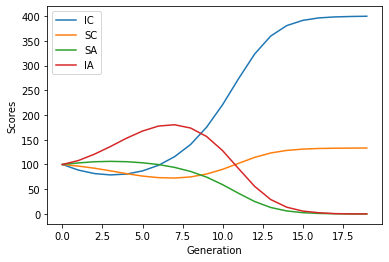

In [4]:
bag = getMem(1,1)
e = Ecological(g, bag, 100)
e.run()
ranking = e.historic.iloc[e.generation].rank(0, method="min", ascending=False)
score = e.historic.iloc[e.generation]
agr = getAgressivityClasses(bag)

# Generate the data with mean of ranks and scores
tab = pd.DataFrame(
            np.nan, ["IC","SC","IA", "SA"], ["Mean of ranks","Mean of scores"]
        )
for key in agr:
    ranks = []
    scores = []
    for strat in agr[key]:
        ranks += [ranking[strat.name]]
        scores += [score[strat.name]]
        
    tab.at[key, "Mean of ranks"] = np.mean(ranks)
    tab.at[key, "Mean of scores"] = np.mean(scores)
pd.options.display.float_format = '{:,.0f}'.format   
print(tab)

# Generate the graph with mean of scores 
ranksIC, ranksSC, ranksIA, ranksSA = [], [], [], []
for i in range(e.generation):
    rIC = 0
    rSC = 0
    rIA = 0
    rSA = 0
    for key in agr:
        for strat in agr[key]:
            if key == "IC":
                rIC += e.historic.iloc[i][strat.name]
            if key == "SC":
                rSC += e.historic.iloc[i][strat.name]
            if key == "IA":
                rIA += e.historic.iloc[i][strat.name]
            if key == "SA":
                rSA += e.historic.iloc[i][strat.name]
    ranksIC += [np.sum(rIC)/len(agr['IC'])]
    ranksSC += [np.sum(rSC)/len(agr['SC'])]
    ranksIA += [np.sum(rIA)/len(agr['IA'])]
    ranksSA += [np.sum(rSA)/len(agr['SA'])]
                
        

plt.plot(ranksIC, label='IC')
plt.plot(ranksSC, label= 'SC')
plt.plot(ranksSA, label='SA')
plt.plot(ranksIA, label='IA')
plt.ylabel('Scores')
plt.xlabel('Generation')
plt.legend()
plt.show()
        